# Character LMs for Conjoined Word Separation
## Intro

Conjoined words are words that __wrongly consist of two words__, but they shouldn't be. Examples are _"theproblem"_, _"extremecircumstances"_, _"helloworld"_, etc.
We'll explore how we can use a pair of character-level language models to detect them and separate them. We'll achieve this by using the powerful fastai v1 library which provides almost everything out of the box!

In [2]:
from fastai import *
from fastai.text import *
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

%reload_ext autoreload
%autoreload 2

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Step 0) Load the data

The data consists of:
- a vocabulary, which is a mapping from an integer id to a character
- train ids - the integer ids encoding the training texts
- val_ids - the integer ids encoding the validation texts



First let's load up the vocabulary

In [2]:
vocab = Vocab(np.load('/data/char-lm-fastai/tmp/itos.pkl'))
vocab.itos[:10]

['xxunk', 'xxpad', ' ', 'e', 'n', 't', 'a', 'o', 'i', 's']

We can use the vocabulary to transform from integer ids to characters and vice-versa. For example:

In [3]:
text = "make neural networks uncool again"
as_ids = [vocab.stoi[c] for c in text]
print("As ids:", as_ids)
back2txt = ''.join(vocab.itos[i] for i in as_ids)
print("As text:", back2txt)

As ids: [16, 6, 29, 3, 2, 4, 3, 15, 10, 6, 11, 2, 4, 3, 5, 25, 7, 10, 29, 9, 2, 15, 4, 12, 7, 7, 11, 2, 6, 20, 6, 8, 4]
As text: make neural networks uncool again


Next, let's load up the training data and validation data. Each row in the data is a list of integer ids corresponding to the characters in the vocab

In [4]:
train_ids = np.load('/data/char-lm-fastai/tmp/train_ids.npy')
val_ids = np.load('/data/char-lm-fastai/tmp/valid_ids.npy')

In [5]:
display(f"train shape {train_ids.shape}")
display(f"val shape{val_ids.shape}")
print("Example article:")
''.join([vocab.itos[x] for x in train_ids[0]])

'train shape (2063146,)'

'val shape(106529,)'

Example article:


'bosrevlon inc . said it would exit china , where sales of its ... endoftitle cosmetics maker revlon to exit china revlon inc . said it would exit china , where sales of its cosmetics have been falling , and cut more than num_1000_1000000 jobs as part of a restructuring designed to save about $ num_10_100 million a year . revlon , owner of the almay cosmetics brand and sinful colors nail polish , said in a filing that its chinese operations accounted for about num_1_10 percent of total net sales . the company posted net sales of $ num_1_10 billion in num_1000_1000000'

# Step 1) Forward Language Model
The first step to training is to create a data bunch. A databunch is a utility class which takes care of a lot of the boilerplate code, that is often missed or slightly wrong. It takes care of:
- loading up batches in the correct, making sure that the last batch is well-formed
- shuffles the training data
- loads up the data onto a particular device, e.g. the GPU
- applying transforms to the data, see the next section for an example

In [7]:
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/tmp', vocab=vocab, 
                                     train_ids= train_ids,
                                     valid_ids = val_ids,
                                     bs = 512)

Now that we have the data, we are ready to define a model and train it. In fastai, you actually create a learner which contains a default model architecture which works great for language models.

In [8]:
vocab_sz = len(vocab.itos)
emb_sz = 100
n_hid = 300

learn = language_model_learner(databunch, emb_sz=emb_sz, nh=n_hid,nl =1 ,drop_mult=0.1, tie_weights=False)
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(73, 100, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(73, 100, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(100, 100)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=100, out_features=73, bias=True)
    (output_dp): RNNDropout()
  )
)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


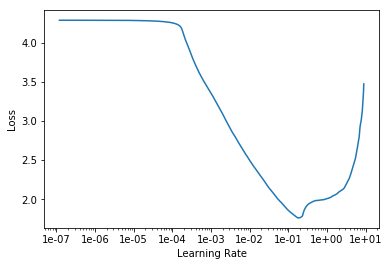

In [9]:
learn.lr_find(start_lr=1e-7, num_it=1000)
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,1.132079,1.080761,0.684524
2,1.117037,1.057644,0.690922


In [10]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.120265,1.058051,0.690958
2,1.111304,1.052797,0.692079
3,1.114191,1.047341,0.693690
4,1.101823,1.043485,0.694640
5,1.106486,1.042297,0.694967


Now, save the model, so we can use it later:

In [11]:
learn.save('fwd_lm')

## Step 2) Backwards Language Model
There is only one difference between a forward and a backward language model - the backwards LM receives and trains on the text in reverse. In fastai, this is achieved by a simple code change - set `backwards=True` when defining the databunch. The library then takes care of reversing the text when making the batches. The rest of the code is the same.

In [6]:
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/tmp', vocab=vocab, 
                                     train_ids= train_ids,
                                     valid_ids = val_ids,
                                     bs = 512,
                                     backwards=True) # Set backwards to true

In [7]:
vocab_sz = len(vocab.itos)
emb_sz = 100
n_hid = 300

learn = language_model_learner(databunch, emb_sz=emb_sz, nh=n_hid,nl =1 ,drop_mult=0.1, tie_weights=False)
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(73, 100, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(73, 100, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(100, 100)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=100, out_features=73, bias=True)
    (output_dp): RNNDropout()
  )
)

In [7]:
learn.fit_one_cycle(2, 3e-3)

epoch,train_loss,valid_loss,accuracy
1,1.147232,1.087566,0.684777
2,1.135380,1.066207,0.689873


In [9]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,1.124710,1.066150,0.690069
2,1.122078,1.062162,0.690919
3,1.131940,1.056962,0.692366
4,1.116715,1.052380,0.693597
5,1.129248,1.051330,0.693889


In [10]:
learn.save('bwd_lm')

# Step 3) Split conjoined words
To identify and split conjoined words, we'll require several conditions to be met:
1. The fwd and bwd language models need to agree that there is a high probability for a space at that position in the text.
2. The unsplit word is not in the provided word vocabulary
3. Both the split words are in the provided word vocabulary
4. Inserting the space leads to a lower average log likelihood for the fwd and backward models

## Step 3.1) Load the vocabs and models

In [3]:
vocab = Vocab(np.load('/data/char-lm-fastai/tmp/itos.pkl'))
word_vocab = set(np.load('/data/suzi/v5/id2w.pkl'))

train_ids = np.zeros((512, 120))
valid_ids = np.zeros((512, 120))
databunch = TextLMDataBunch.from_ids('/data/char-lm-fastai/', vocab=vocab, train_ids=train_ids, valid_ids=valid_ids,
                                     bs=512, backwards=False)

fwd_learn = language_model_learner(databunch, emb_sz=100, nh=300, nl=1, drop_mult=0., tie_weights=False)
fwd_learn.load('/data/char-lm-fastai/tmp/models/fwd_lm')
fwd = fwd_learn.model.cpu()

bwd_learn = language_model_learner(databunch, emb_sz=100, nh=300, nl=1, drop_mult=0., tie_weights=False)
bwd_learn.load('/data/char-lm-fastai/tmp/models/bwd_lm')
bwd = bwd_learn.model.cpu()

## Step 3.2) Encode text
To use our language models in a custom way, we'll have to get our hands dirty. First we'll have to reimplement some of the functionality of the databunch - transform a list of strings to a torch tensor.

To achieve this, we will sort the items in the batch by length and pad the trailing whitespace with 1.

In [4]:
def get_sequences(txts:list, vocab:Vocab, reverse=False):
    """
    Transforms a list of LongTensors to a padded long tensor
    :param sequences:
    :param reverse:
    :return: a tuple res, lens where res is of shape TxB and lens is the lengths of the items in the batch.
    """
    sequences = [torch.LongTensor(vocab.numericalize(['bos'] + [x for x in txt] + ['bos'])) for txt in txts]
    if reverse:
        sequences = [torch.LongTensor(s.numpy()[::-1].copy()) for s in sequences]
    sorted_sequences = sorted(sequences, key=lambda x: x.size(), reverse=True)
    packed_sequences = pack_sequence(sorted_sequences)
    return pad_packed_sequence(packed_sequences, padding_value=1)


In [5]:
sample_input = ['make neural nets uncool again', 'tesla stock plunges after ceo smokes pot']
sample_sequences, sample_lens = get_sequences(sample_input, vocab)
sample_sequences

tensor([[37, 37],
        [ 5, 16],
        [ 3,  6],
        [ 9, 29],
        [11,  3],
        [ 6,  2],
        [ 2,  4],
        [ 9,  3],
        [ 5, 15],
        [ 7, 10],
        [12,  6],
        [29, 11],
        [ 2,  2],
        [18,  4],
        [11,  3],
        [15,  5],
        [ 4,  9],
        [20,  2],
        [ 3, 15],
        [ 9,  4],
        [ 2, 12],
        [ 6,  7],
        [19,  7],
        [ 5, 11],
        [ 3,  2],
        [10,  6],
        [ 2, 20],
        [12,  6],
        [ 3,  8],
        [ 7,  4],
        [ 2, 37],
        [ 9,  1],
        [16,  1],
        [ 7,  1],
        [29,  1],
        [ 3,  1],
        [ 9,  1],
        [ 2,  1],
        [18,  1],
        [ 7,  1],
        [ 5,  1],
        [37,  1]])

## Step 3.3) Predict

Next, we need a method which can take these tensors, run them through the model and return the most likely texts.

In [6]:
def predict(model: nn.Module, txt:torch.LongTensor, lens:np.array, vocab: Vocab):
    """
    Applies the model and returns the results as a string
    :param model:
    :param txt:
    :param lens:
    :param vocab:
    :return:
    """
    model.eval()
    model.reset()
    forward_preds = model(txt)[0]
    forward_preds = forward_preds.argmax(-1).view(txt.size(0), -1).t()
    res = []
    for preds, length in zip(forward_preds, lens):
        res.append(''.join(vocab.itos[preds[i]] for i in range(length)))
    return res

In [7]:
sample_preds = predict(fwd, sample_sequences, sample_lens, vocab)
display(sample_input[1], sample_preds[0][:-2])

'tesla stock plunges after ceo smokes pot'

'chcta muock irange  anter too starer ars'

## Step 3.4) Score text
We need to be able to compare the quality of different texts under the model. More likely sequences should receive higher scores than less likely ones. To achieve this, we will look at the average log likelihood of the sequences.

In [8]:
def score_txt(txt:str, model:nn.Module, vocab: Vocab):
    """
    Computes the average log likelihood of the text under the model
    :param txt: 
    :param model: 
    :param vocab: 
    :return: 
    """
    numericalized = vocab.numericalize(['bos'] + [x for x in txt] + ['bos'])
    model.reset()
    model.eval()
    inp = torch.LongTensor([numericalized]).t()
    preds = F.log_softmax(model(inp)[0], dim=0)
    score = 0.
    for pred, actual in zip(preds, numericalized[1:]):
        score += pred[actual]
    return score / len(txt)


In [9]:
for txt in ['financialresults', 'fin ancialresults',  'financial results']:
    display(f"{txt} likelihood: {score_txt(txt, fwd, vocab).detach().numpy()} ")

'financialresults likelihood: -2.5872597694396973 '

'fin ancialresults likelihood: -3.891763925552368 '

'financial results likelihood: -1.7246867418289185 '

## Step 3.5) Bringing it all together

The rest is just boiler plate:
1. we encode the text
2. we use it to predict via the two language models
3. for each text
  1. we identify potential split points
  2. we check if the split is good according to the rules outlined in the beginning of the section
  

In [17]:
def get_concordance(orig_txt,i, concordance_len=30):
    """
    Returns the start and end indices of a concordance of len concordance_len.
    The function pays attention to the start and end of the orig_txt 
    so that the returned indices are within the range of the string
    :param orig_txt: the original text
    :param i: the index around which to search for concordances
    
    """
    concordance_len = 30
    start = max(0, i - concordance_len)
    end = min(len(orig_txt), i + concordance_len)
    return start, end

def split_word(orig_txt, i):
    """
    Returns a tuple (original_word, left_word, right_word) extracting them from the orig_txt
    """
    r_num_chars = orig_txt[i:].index(' ') if ' ' in orig_txt[i:] else 0
    l_num_chars = orig_txt[:i][::-1].index(' ') if ' ' in orig_txt[:i] else 0
    word = ''.join(orig_txt[i-l_num_chars:i+r_num_chars])
    l_word = ''.join(orig_txt[i-l_num_chars:i])
    r_word = ''.join(orig_txt[i:i+r_num_chars])
    return word, l_word, r_word


def is_split_good(word:str, l_word:str, r_word:str, orig_txt, i, model, bwd_model, word_vocab:set):
    """
    A split is good if 
    1) the original word is not in the word vocab
    2) the left and right words are in the word vocab 
    3) the average log likelihood of the text under the models increases.
    """
    if word in word_vocab:
        return False
    if l_word not in word_vocab or r_word not in word_vocab:
        return False
    with_split = ''.join(orig_txt[:i]) + ' ' + ''.join(orig_txt[i:])
    orig_score = score_txt(orig_txt, model, vocab) + score_txt(orig_txt[::-1], bwd_model, vocab)
    split_score = score_txt(with_split, model, vocab) + score_txt(with_split[::-1], bwd_model, vocab)
    return split_score > orig_score

In [18]:
def split_conjoined_words(txts: list, model: SequentialRNN, bwd_model: SequentialRNN, vocab: Vocab, word_vocab: set):
    # Encode
    fwd_sequences, lens = get_sequences(txts, vocab)
    bwd_sequences, bwd_lens = get_sequences(txts, vocab, reverse=True)
    # Predict
    forward_preds = predict(model, fwd_sequences, lens, vocab)
    backward_preds = predict(bwd_model, bwd_sequences, bwd_lens, vocab)
    for seq_idx, (seq, seq_len, fwd_pred, bwd_pred) in enumerate(zip(fwd_sequences.t(), lens, forward_preds, backward_preds)):
        # Align predictions and original text
        orig_txt = [vocab.itos[x] for x in seq[1:seq_len-1] if x != 1]
        fwd_pred = fwd_pred[:-1]
        bwd_pred = bwd_pred[:-1][::-1]
        for i in range(1, len(orig_txt)):
            if orig_txt[i] != ' ' and fwd_pred[i] == ' ' and bwd_pred[i] == ' ':
                start, end = get_concordance(orig_txt, i)
                word, l_word, r_word = split_word(orig_txt, i)
                if is_split_good(word, l_word, r_word, orig_txt, i, model, bwd_model, word_vocab):
                    yield({'original': ''.join(orig_txt[start:end]), 'split': ''.join(orig_txt[start:i]) + ' ' + ''.join(orig_txt[i:end])})


In [19]:
pd.set_option('max_colwidth', 300)

bs=2048
for i, chunk in enumerate(pd.read_json('/data/char-lm-fastai/train.jsonl', lines=True, chunksize=bs)):
    if i > 10:
        break
    text = chunk['tokens']
    display(pd.DataFrame(list(split_conjoined_words(text, fwd, bwd, vocab, word_vocab))))
    

,original,split
0,", num_1000_1000000 . dr . gotto was elected as a class ii d",", num_1000_1000000 . dr . got to was elected as a class ii d"
1,"inance conference endoftitle -vivint 's president , alex dun","inance conference endoftitle - vivint 's president , alex dun"
2,"um_1_10 % in constant currencyfiscal ye ... los angeles , ma","um_1_10 % in constant currency fiscal ye ... los angeles , ma"
3,platinum level for their greenleader hotel program . establi,platinum level for their green leader hotel program . establi
4,tse num_100_1000 index ( indexftse : ukx ) to briefly inch u,tse num_100_1000 index ( index ftse : ukx ) to briefly inch u
5,t ' aaasf ' ; outlook stable ;-- class b affirmed at ' aaasf,t ' aaasf ' ; outlook stable ; -- class b affirmed at ' aaasf
6,t ' aaasf ' ; outlook stable ;-- class c affirmed at ' aasf,t ' aaasf ' ; outlook stable ; -- class c affirmed at ' aasf
7,g a topless barber shop . hairdresser / stripper bree franci,g a topless barber shop . hair dresser / stripper bree franci
8,urray digital content producer- dallas business journal | |,urray digital content producer - dallas business journal | |
9,- num_1_10 ( us abs ) / creditdesk / reports / report_frame.,- num_1_10 ( us abs ) / credit desk / reports / report_frame.


,original,split
0,arch and markets : global homewares market num_1000_1000000,arch and markets : global home wares market num_1000_1000000
1,ket endoftitle the global homewares market has several drive,ket endoftitle the global home wares market has several drive
2,the global economy . the homewares market in emerging count,the global economy . the home wares market in emerging count
3,arch and markets : global homewares market num_1000_1000000,arch and markets : global home wares market num_1000_1000000
4,eir offering . the global homewares market has several drive,eir offering . the global home wares market has several drive
5,ation of amantys power insighttm protocol with avago 's 50mb,ation of amantys power insight tm protocol with avago 's 50mb
6,he past financial year include:- customer,he past financial year include :- customer
7,usive agreement to equip unitypoint health with radiotherapy,usive agreement to equip unity point health with radiotherapy
8,zed treatment systems at unitypoint health hospitals across,zed treatment systems at unity point health hospitals across
9,ntered an agreement with unitypoint health to be its exclusi,ntered an agreement with unity point health to be its exclusi


,original,split
0,"been filed against altair nanotechnologies , inc . ( "" altai","been filed against altair nano technologies , inc . ( "" altai"
1,nergy services provider energyexcel llp to further expand it,nergy services provider energy excel llp to further expand it
2,"management business of energyexcel llp , an independent ene","management business of energy excel llp , an independent ene"
3,ecording artists through soundexchange in the united states,ecording artists through sound exchange in the united states
4,hmallow kremetm - filled ghostbuster treats inspired by the,hmallow kremetm - filled ghost buster treats inspired by the
5,me of $ num_10_100 million andnet income per diluted share o,me of $ num_10_100 million and net income per diluted share o
6,nergy services provider energyexcel llp to further expand it,nergy services provider energy excel llp to further expand it
7,"management business of energyexcel llp , an independent ene","management business of energy excel llp , an independent ene"
8,1000 million . it 's operatingincome totaled $ 6.48billion .,1000 million . it 's operating income totaled $ 6.48billion .
9,100 in after - hours trade . -jim jelter ;,100 in after - hours trade . - jim jelter ;


,original,split
0,sports . the traditional showgrounds at the aachen soers wi,sports . the traditional show grounds at the aachen soers wi
1,"icates , series 2015-sshp ( cgcmt 2015-sshp ) endoftitle inf","icates , series 2015-sshp ( cg cmt 2015-sshp ) endoftitle inf"
2,te enterprise - dubbed bmo skyway - was recognized as the in,te enterprise - dubbed bmo sky way - was recognized as the in
3,keep business customers happy- f5 networks ( nasdaq : ffiv,keep business customers happy - f5 networks ( nasdaq : ffiv
4,"g on american eagle outfittersaeo , and raised the price tar","g on american eagle outfitters aeo , and raised the price tar"
5,records num_1_10 % hike in q3fy14 sales endoftitle nyse lis,records num_1_10 % hike in q3 fy14 sales endoftitle nyse lis
6,"vhc , swir , crus , tqnt , rfmd ) endoftitle we looked at t","vhc , swir , crus , tqnt , rf md ) endoftitle we looked at t"
7,company to be named wuxi nextcode genomics . the company no,company to be named wuxi next code genomics . the company no
8,"s literally using malcolm gladwell 's book , david and golia","s literally using malcolm glad well 's book , david and golia"
9,pany has num_1000_1000000 fulltime workers and num_1000_1000,pany has num_1000_1000000 full time workers and num_1000_1000


,original,split
0,: the num_1000_1000000 tripletree iaward for connected heal,: the num_1000_1000000 triple tree iaward for connected heal
1,on of the rosalynn carter caregiving institute military care,on of the rosalynn carter care giving institute military care
2,ceipts ( drivers ) of the j.p.morgan putters / drivers trust,ceipts ( drivers ) of the j.p. morgan putters / drivers trust
3,"ounder of bazaarvoice and coremetrics , and scott mcintosh ,","ounder of bazaarvoice and core metrics , and scott mcintosh ,"
4,"founder of bazaarvoice , coremetrics and hurt family invest","founder of bazaarvoice , core metrics and hurt family invest"
5,", announced an agreement withlos angeles - based solar deve",", announced an agreement with los angeles - based solar deve"
6,adwp ) awarded to sunedison injuly num_1000_1000000 . the lo,adwp ) awarded to sunedison in july num_1000_1000000 . the lo
7,plans to sell financial assetsusa todaygeneral electric ( ge,plans to sell financial assets usa todaygeneral electric ( ge
8,"ent . charlotte motor speedwayis located in concord , nc","ent . charlotte motor speedway is located in concord , nc"
9,custodial receipts of the j.p.morgan putters / drivers serie,custodial receipts of the j.p. morgan putters / drivers serie


,original,split
0,num_10_100 % national revenue$ num_1000_1000000 $ num_1000_,num_10_100 % national revenue $ num_1000_1000000 $ num_1000_
1,"d as platinum sponsors of robouniverse san diego , taking pl","d as platinum sponsors of robo universe san diego , taking pl"
2,"g provider of automotive undercar repair and tire services ,","g provider of automotive under car repair and tire services ,"
3,"meltzer & check , llp remindswayfair inc . ( "" wayfair "" or","meltzer & check , llp reminds wayfair inc . ( "" wayfair "" or"
4,"co "" or "" company "" ) ( nasdaqcm : vdsi ) and several office","co "" or "" company "" ) ( nasdaq cm : vdsi ) and several office"
5,"onal government endoftitle jinhua , china , june num_10_100","onal government endoftitle jin hua , china , june num_10_100"
6,pin off its holding in alibaba- first midwest bancorp inc .,pin off its holding in alibaba - first midwest bancorp inc .
7,ficate of excellence and greenleaders silver awards endoftit,ficate of excellence and green leaders silver awards endoftit
8,ficate of excellence and greenleaders silver awards hotel in,ficate of excellence and green leaders silver awards hotel in
9,ficate of excellence and greenleaders silver awards endoftit,ficate of excellence and green leaders silver awards endoftit


,original,split
0,"ars and midsize suvs worldwide- westrock ( nyse : wrk ) , pr","ars and midsize suvs worldwide - westrock ( nyse : wrk ) , pr"
1,cer patient with moderate overexpression of the fgfr2b prote,cer patient with moderate over expression of the fgfr2b prote
2,cturer broadcom limited ( avgo- analyst report ) recorded so,cturer broadcom limited ( avgo - analyst report ) recorded so
3,"12-month period , the easternmost region of dominican repub","12-month period , the eastern most region of dominican repub"
4,"doftitle facebook ipo facebookfacebook , named the best plac","doftitle facebook ipo facebook facebook , named the best plac"
5,oftitle manchester united goalkeeper david de gea organised,oftitle manchester united goal keeper david de gea organised
6,endoftitle ( youtube / windowstube ) screenshot from the off,endoftitle ( youtube / windows tube ) screenshot from the off
7,p five on this year 's list ofthe num_10_100 best companies,p five on this year 's list of the num_10_100 best companies
8,htest . once you've passed theintense interview process at e,htest . once you've passed the intense interview process at e
9,"chelgillett , business insiderif you're faced with the decis","chelgillett , business insider if you're faced with the decis"


,original,split
0,"g provider of automotive undercar repair and tire services ,","g provider of automotive under car repair and tire services ,"
1,tners with shire for their eyelove ( tm ) dry eye disease aw,tners with shire for their eye love ( tm ) dry eye disease aw
2,tners with shire for their eyelove ( tm ) dry eye disease aw,tners with shire for their eye love ( tm ) dry eye disease aw
3,"1000_1000000 . about caretrusttm caretrust reit , inc . is a","1000_1000000 . about caretrust tm caretrust reit , inc . is a"
4,rates the tricentis tosca testsuite into accenture 's applic,rates the tricentis tosca test suite into accenture 's applic
5,carlyle lp : total sells atotech speciality chemical arm t,carlyle lp : total sells ato tech speciality chemical arm t
6,ntract endoftitle by commodityonline ( commodity online ) co,ntract endoftitle by commodity online ( commodity online ) co
7,"cedt richmond , va ( wwbt ) -money may be coming to thousan","cedt richmond , va ( wwbt ) - money may be coming to thousan"
8,cash * eqt midstream partners- acquisition was effective oc,cash * eqt midstream partners - acquisition was effective oc
9,to a survey by tivo 's digitalsmiths unit . reuters / mike b,to a survey by tivo 's digital smiths unit . reuters / mike b


,original,split
0,"supreme industries , inc. ( ""supreme industries "" or the ""","supreme industries , inc. ( "" supreme industries "" or the """
1,"nst ferrellgas partners , l.p.fgp num_1_10 % . investor loss","nst ferrellgas partners , l.p. fgp num_1_10 % . investor loss"
2,nes to power inaugural collegefest travel show endoftitle bo,nes to power inaugural college fest travel show endoftitle bo
3,"n- ( business wire ) - studentuniverse , the world 's leadin","n- ( business wire ) - student universe , the world 's leadin"
4,o launch the inaugural collegefest travel show . the campus,o launch the inaugural college fest travel show . the campus
5,s action lawsuit against adeptus health inc . and reminds in,s action lawsuit against adept us health inc . and reminds in
6,"s action lawsuit against adeptus health inc . ( "" adeptus he","s action lawsuit against adept us health inc . ( "" adeptus he"
7,"adeptus health inc . ( "" adeptus health "" or the "" company ""","adeptus health inc . ( "" adept us health "" or the "" company """
8,jections per year affirmed - -inclisiran demonstrated,jections per year affirmed - - inclisiran demonstrated
9,volcom and more share digitalfirst marketing tips at num_10,volcom and more share digital first marketing tips at num_10


,original,split
0,tupsleadershipthe next economyback to the rootsfood / bevera,tupsleadershipthe next economy back to the rootsfood / bevera
1,next economyback to the rootsfood / beverage a recent move,next economyback to the roots food / beverage a recent move
2,"title lausanne , switzerland -wednesday , march 1st num_1000","title lausanne , switzerland - wednesday , march 1st num_1000"
3,m_10_100 million from snap ipochicago tribune snap ipo shows,m_10_100 million from snap ipo chicago tribune snap ipo shows
4,m_10_100 million from snap ipolos angeles times marketwatch,m_10_100 million from snap ipo los angeles times marketwatch
5,"rnize data production businesscontracts esri , harris corpor","rnize data production business contracts esri , harris corpor"
6,busy airport and reducing overflight noise for millions of n,busy airport and reducing over flight noise for millions of n
7,media / images / us / personalmobility / maven/0121maven / g,media / images / us / personal mobility / maven/0121maven / g
8,o lead the india unit . ganesha notes that aries happens to,o lead the india unit . ganesh a notes that aries happens to
9,". pmi is committed to a smokefree future , where noncombust",". pmi is committed to a smoke free future , where noncombust"


,original,split
0,s family of high - speed photodetectors . the 100ghz balance,s family of high - speed photo detectors . the 100ghz balance
1,"ublic protest in the octagon -saturday , num_10_100 march nu","ublic protest in the octagon - saturday , num_10_100 march nu"
2,t - year cbs series . with midseason legal drama doubt yanke,t - year cbs series . with mid season legal drama doubt yanke
3,after num_1_10 episodes ; midseason cop drama training day,after num_1_10 episodes ; mid season cop drama training day
4,sr ) today introduced its waveanalyzer 100s compact optical,sr ) today introduced its wave analyzer 100s compact optical
5,"d and manufacturing . the waveanalyzer 100s , together with","d and manufacturing . the wave analyzer 100s , together with"
6,r series a family and the waveanalyzer 1500s high resolution,r series a family and the wave analyzer 1500s high resolution
7,hdr capture to select devicesandroid police lightroom mobil,hdr capture to select devices android police lightroom mobil
8,hdr capture on ios and androidtechcrunch adobe updates light,hdr capture on ios and android techcrunch adobe updates light
9,with ' authentic hdr ' & moreappleinsider ( press release ),with ' authentic hdr ' & more appleinsider ( press release )
